In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio as rio
import seaborn as sns
import os, glob
from tifffile import imsave
import cv2
import tarfile
import pyproj as proj
from osgeo import gdal
import rasterio
import itertools
import os
import csv
from scipy.interpolate import griddata
#from arcpy import env
from rasterstats import zonal_stats
%matplotlib inline

path = os.getcwd()

In [2]:
path='E:\program'
os.chdir(path)

# extract files and make csv-files

In [17]:
#extract files to csv
import pandas
inputFolder=r'CMIP\tar_open\West_Coast'
for i in range(3,len(os.listdir(inputFolder))):
    model_name=os.listdir(inputFolder)[i]
    inputPath = os.path.join(r'CMIP\tar_open\West_Coast', model_name , 'ssp126','PrecipData')
    df = pandas.read_csv(inputPath,header=None)
    df['split'] = df[0].str.split(' ')
    amount_rows=len(df['split'])
    amount_columns=len(df['split'][0])
    list_columns=[]
    for i in range(amount_columns):
        list_columns.append(str(i))
    df2=pd.DataFrame(columns=list_columns)
    for i in range(amount_rows):
        df2.loc[i]=df['split'][i]
    outputPath = os.path.join(r'CMIP\csv_files_126', model_name + '-ssp126' +'.csv')
    df2.to_csv(outputPath, index = False)

In [18]:
#extract files to csv
import pandas
inputFolder=r'CMIP\tar_open\West_Coast'
for i in range(3,len(os.listdir(inputFolder))):
    model_name=os.listdir(inputFolder)[i]
    inputPath = os.path.join(r'CMIP\tar_open\West_Coast', model_name , 'ssp245','PrecipData')
    df = pandas.read_csv(inputPath,header=None)
    df['split'] = df[0].str.split(' ')
    amount_rows=len(df['split'])
    amount_columns=len(df['split'][0])
    list_columns=[]
    for i in range(amount_columns):
        list_columns.append(str(i))
    df2=pd.DataFrame(columns=list_columns)
    for i in range(amount_rows):
        df2.loc[i]=df['split'][i]
    outputPath = os.path.join(r'CMIP\csv_files_245', model_name + '-ssp245' +'.csv')
    df2.to_csv(outputPath, index = False)

# open csv files and select the region of interest 

In [4]:
#creates usable df from csv
def func1_usable_df(df3):
    df3=df3.fillna(0)
    df3=df3.iloc[1:]
    df3.iloc[:,0]=df3.iloc[:,0].astype(int)
    df3.iloc[:,1]=df3.iloc[:,1].astype(int)
    df3.iloc[:,2]=df3.iloc[:,2].astype(int)
    #make dates as index
    df3.iloc[:,0]=df3.iloc[:,0].astype(str)
    df3.iloc[:,1]=df3.iloc[:,1].astype(str)
    df3.iloc[:,2]=df3.iloc[:,2].astype(str)
    df3.iloc[:,0]=df3.iloc[:,0]+'-'+df3.iloc[:,1]+'-'+df3.iloc[:,2]
    df3=df3.set_index(0)
    df3 = df3.drop(columns=[1, 2]) 
    df3.iloc[0,0]=0
    df3.iloc[1,0]=0
    #remove useless columns outside mumbai extent
    df3.iloc[0]=df3.iloc[0].astype(float)
    df3.iloc[1]=df3.iloc[1].astype(float)
    df3 = df3.drop(df3.columns[df3.iloc[0] >74.05],axis=1)
    df3 = df3.drop(df3.columns[df3.iloc[1] <18.3],axis=1)
    df3 = df3.drop(df3.columns[df3.iloc[1] >20.2],axis=1) 
    for i in range(2016,2101,4):
        i=str(i)
        i=i+'-2-29'
        try:
            df3=df3.drop([i])
        except:
            pass
    return df3

In [132]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_370'
dictionary_370={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_370[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [5]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_585'
dictionary_585={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_585[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [10]:
#takes model average
#df4=(dictionary_585['ACCESS-CM2-ssp585']+dictionary_585['ACCESS-ESM1-5-ssp585']
#     +dictionary_585['BCC-CSM2-MR-ssp585']
#     +dictionary_585['CanESM5-ssp585']+dictionary_585['EC-Earth3-ssp585']
#     +dictionary_585['EC-Earth3-Veg-ssp585']+dictionary_585['INM-CM4-8-ssp585']
#     +dictionary_585['INM-CM5-0-ssp585']+dictionary_585['MPI-ESM1-2-HR-ssp585']
#     + dictionary_585['MPI-ESM1-2-LR-ssp585']+ dictionary_585['MRI-ESM2-0-ssp585']
#     +dictionary_585['NorESM2-LM-ssp585']+dictionary_585['NorESM2-MM-ssp585'])*(1/13)

In [206]:
df4=dictionary_585['CanESM5-ssp585']

In [141]:
df4

4       5       6       7       11      12      13      14  \
0                                                                            
0-0-0       72.875  72.875  72.875  72.875  73.125  73.125  73.125  73.125   
0-0-0       19.375  19.625  19.875  20.125  18.375  18.625  18.875  19.125   
2015-1-1     0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   
2015-1-2     3.460   4.080   4.540   4.340   3.420   4.990   4.670   4.360   
2015-1-3     3.870   4.520   4.840   4.460   4.170   5.730   5.220   4.520   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2100-12-27  30.480  36.970  41.340  44.470  14.720  21.510  26.230  28.550   
2100-12-28  30.020  32.470  33.330  32.990  30.240  34.180  32.590  31.010   
2100-12-29  30.620  33.540  34.690  34.770  30.730  35.160  34.390  33.480   
2100-12-30  30.980  29.450  25.800  21.110  48.840  49.320  44.930  38.690   
2100-12-31  11.440  11.280   9.900   7.880  20.420  22.410  20.310  17.880   

                15      16  ...      29      30      31      32      33  \
0                           ...                                           
0-0-0       73.125  73.125  ...  73.375  73.375  73.375  73.375  73.375   
0-0-0       19.375  19.625  ...  18.625  18.875  19.125  19.375  19.625   
2015-1-1     0.000   0.000  ...   0.000   0.000   0.000   0.000   0.000   
2015-1-2     4.130   5.310  ...   4.840   4.810   4.480   4.810   6.600   
2015-1-3     4.100   5.020  ...   5.130   4.780   4.210   4.100   5.200   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2100-12-27  31.350  38.430  ...  17.560  21.930  24.610  29.620  39.460   
2100-12-28  30.050  33.710  ...  26.250  26.080  25.690  27.540  33.910   
2100-12-29  32.870  37.160  ...  28.380  28.720  29.150  31.910  39.850   
2100-12-30  33.810  33.830  ...  40.500  37.090  33.300  32.980  36.910   
2100-12-31  15.810  16.670  ...  20.370  19.270  17.300  18.030  21.470   

                34      35      47      48      49  
0                                                   
0-0-0       73.375  73.375  73.625  73.625  73.625  
0-0-0       19.875  20.125  19.375  19.625  20.125  
2015-1-1     0.000   0.410   0.000   0.000   0.230  
2015-1-2     7.150   5.900   3.310   4.480   3.390  
2015-1-3     5.500   4.420   2.760   3.360   2.250  
...            ...     ...     ...     ...     ...  
2100-12-27  39.900  37.990  18.040  25.340  22.520  
2100-12-28  32.070  28.490  16.990  21.750  16.880  
2100-12-29  38.190  34.720  21.590  28.550  23.750  
2100-12-30  31.320  24.140  21.780  25.900  16.600  
2100-12-31  19.550  15.610  13.680  17.000  12.000  

[31392 rows x 23 columns]

In [142]:
df4.loc['2015-7-30']

4     113.83
5     114.94
6     115.80
7     111.39
11    136.65
12    140.18
13    137.03
14    122.66
15    116.16
16    121.06
17    121.20
18    114.60
28    121.06
29    116.33
30    115.34
31    103.32
32    104.12
33    115.16
34    109.94
35    101.75
47     67.78
48     80.33
49     65.87
Name: 2015-7-30, dtype: float64

In [68]:
df4.iloc[0].min()

72.875

# Rainfall overview of the models

Step1: Divide in three time frames: 2015-2040 (26 years), 2041-2070 (30 years), 2071-2100 (30 years) 
Step2: Average over space to get one single precipitation value per day
Step3: Take the top 30 precipitation values per year
Step4: make a list of all the top 30 precipitation values for a time frame
Step5: Make a histogram for the three time frames

In [35]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [36]:
#rainfall middle 30 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [37]:
#rainfall middle 30 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_370[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

370

In [38]:
a_1=func_max_begin_2('ACCESS-CM2-ssp370')
a_2=func_max_begin_3('ACCESS-CM2-ssp370')
a_3=func_max_begin_4('ACCESS-CM2-ssp370')
b_1=func_max_begin_2('ACCESS-ESM1-5-ssp370')
b_2=func_max_begin_3('ACCESS-ESM1-5-ssp370')
b_3=func_max_begin_4('ACCESS-ESM1-5-ssp370')
c_1=func_max_begin_2('BCC-CSM2-MR-ssp370')
c_2=func_max_begin_3('BCC-CSM2-MR-ssp370')
c_3=func_max_begin_4('BCC-CSM2-MR-ssp370')
d_1=func_max_begin_2('CanESM5-ssp370')
d_2=func_max_begin_3('CanESM5-ssp370')
d_3=func_max_begin_4('CanESM5-ssp370')
e_1=func_max_begin_2('EC-Earth3-ssp370')
e_2=func_max_begin_3('EC-Earth3-ssp370')
e_3=func_max_begin_4('EC-Earth3-ssp370')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp370')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp370')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp370')
g_1=func_max_begin_2('INM-CM4-8-ssp370')
g_2=func_max_begin_3('INM-CM4-8-ssp370')
g_3=func_max_begin_4('INM-CM4-8-ssp370')
h_1=func_max_begin_2('INM-CM5-0-ssp370')
h_2=func_max_begin_3('INM-CM5-0-ssp370')
h_3=func_max_begin_4('INM-CM5-0-ssp370')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp370')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp370')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp370')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp370')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp370')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp370')
k_1=func_max_begin_2('MRI-ESM2-0-ssp370')
k_2=func_max_begin_3('MRI-ESM2-0-ssp370')
k_3=func_max_begin_4('MRI-ESM2-0-ssp370')
l_1=func_max_begin_2('NorESM2-LM-ssp370')
l_2=func_max_begin_3('NorESM2-LM-ssp370')
l_3=func_max_begin_4('NorESM2-LM-ssp370')
m_1=func_max_begin_2('NorESM2-MM-ssp370')
m_2=func_max_begin_3('NorESM2-MM-ssp370')
m_3=func_max_begin_4('NorESM2-MM-ssp370')
a=[a_1,a_2,a_3]
b=[b_1,b_2,b_3]
c=[c_1,c_2,c_3]
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[a,b,c,d,e,f,g,h,i,j,k,l,m]

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


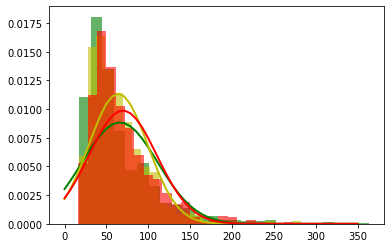

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


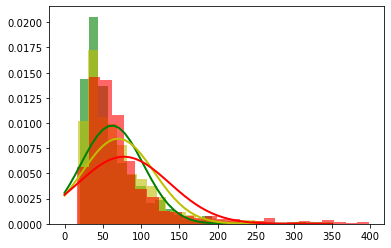

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


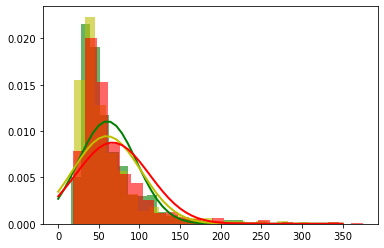

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


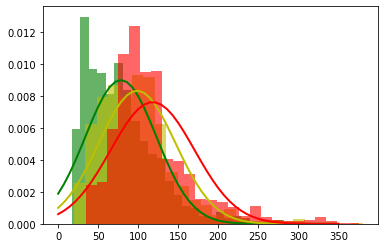

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


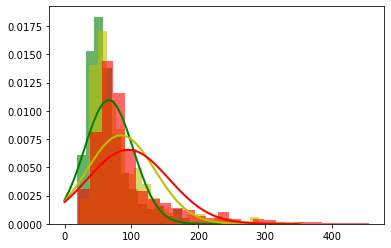

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


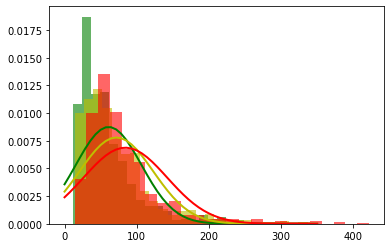

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


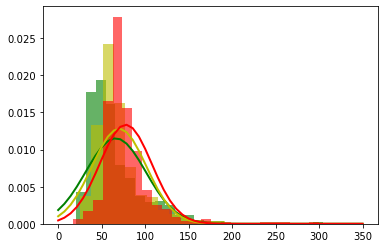

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


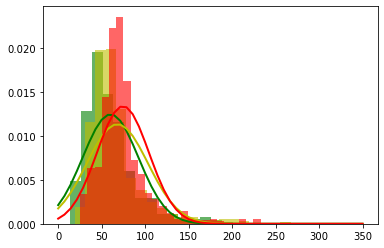

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


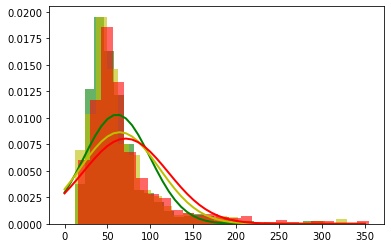

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


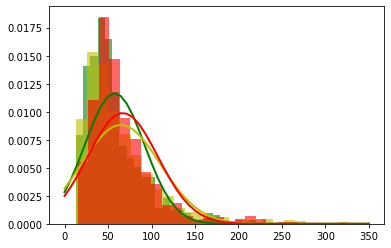

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


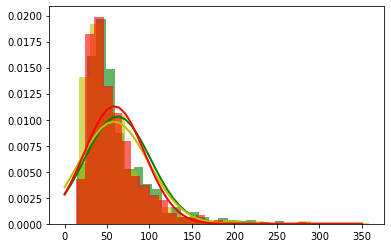

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


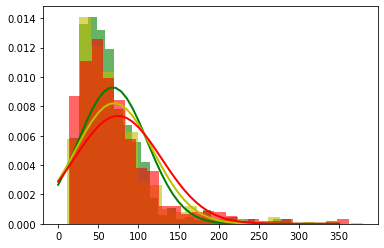

<ipython-input-39-b99f9d86939b>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-39-b99f9d86939b>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-39-b99f9d86939b>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


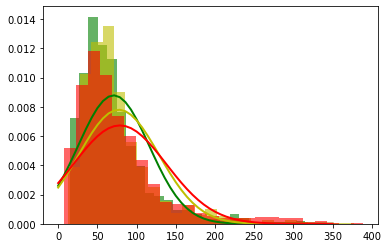

In [39]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_1=np.zeros([13,3])
std_1=np.zeros([13,3])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_1[count]=[mu1,mu2,mu3]
    std_1[count]=[std1,std2,std3]
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_370_'+count2+'.png')
    plt.show()

In [40]:
mu_1

array([[ 66.06196042,  64.15394638,  69.69732319],
       [ 62.11206912,  70.09769469,  77.48680048],
       [ 60.55406466,  59.81081546,  66.94638309],
       [ 78.35625697,  98.6455285 , 117.96066039],
       [ 66.16358082,  84.24353913,  95.22134251],
       [ 61.08470513,  71.85627778,  84.25883913],
       [ 66.21109643,  70.17088937,  77.70833333],
       [ 60.23877982,  68.10060725,  74.5028314 ],
       [ 61.16572018,  64.37291836,  71.13132174],
       [ 57.65664326,  64.72787536,  66.97261739],
       [ 62.40183501,  58.06749034,  58.69928841],
       [ 67.92549833,  69.71266039,  74.42916908],
       [ 70.81574638,  77.42072271,  78.72764203]])

In [41]:
std_1

array([[45.15077403, 35.18360324, 40.37835667],
       [40.87586178, 47.16463234, 59.88493405],
       [36.05379499, 42.17105747, 45.50423279],
       [44.3294077 , 47.88031546, 52.38370459],
       [36.3580313 , 50.89850503, 60.90950444],
       [45.59742695, 51.16889487, 58.02039423],
       [34.64121516, 31.15871455, 29.88288529],
       [32.04700303, 35.22153182, 29.81077061],
       [38.69804984, 46.13077149, 49.57280951],
       [34.28419334, 45.181514  , 40.32727656],
       [38.69525734, 40.61335038, 35.31106831],
       [42.91155839, 48.54274144, 54.24132856],
       [45.39093824, 51.12510991, 59.27299722]])

585

In [42]:
#rainfall first 26 years (2015-2040)
def func_max_begin_2(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(2,9492,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [43]:
#rainfall first 26 years (2041-2070)
def func_max_begin_3(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(9492,20442,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [44]:
#rainfall first 26 years (2070-2100)
def func_max_begin_4(dict_name):
    dictionary_name=dict_name
    c=pd.DataFrame()
    lijstje2=[]
    for i in range(20442,31392,365):
        j=i+365
        df1=dictionary_585[dict_name][i:j]
        df2=df1.mean(axis=1)
        df3=df2.nlargest(n=30).to_list()
        lijstje2.append(df3)
    flat_list = []
    for sublist in lijstje2:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [45]:
a_1=func_max_begin_2('ACCESS-CM2-ssp585')
a_2=func_max_begin_3('ACCESS-CM2-ssp585')
a_3=func_max_begin_4('ACCESS-CM2-ssp585')
b_1=func_max_begin_2('ACCESS-ESM1-5-ssp585')
b_2=func_max_begin_3('ACCESS-ESM1-5-ssp585')
b_3=func_max_begin_4('ACCESS-ESM1-5-ssp585')
c_1=func_max_begin_2('BCC-CSM2-MR-ssp585')
c_2=func_max_begin_3('BCC-CSM2-MR-ssp585')
c_3=func_max_begin_4('BCC-CSM2-MR-ssp585')
d_1=func_max_begin_2('CanESM5-ssp585')
d_2=func_max_begin_3('CanESM5-ssp585')
d_3=func_max_begin_4('CanESM5-ssp585')
e_1=func_max_begin_2('EC-Earth3-ssp585')
e_2=func_max_begin_3('EC-Earth3-ssp585')
e_3=func_max_begin_4('EC-Earth3-ssp585')
f_1=func_max_begin_2('EC-Earth3-Veg-ssp585')
f_2=func_max_begin_3('EC-Earth3-Veg-ssp585')
f_3=func_max_begin_4('EC-Earth3-Veg-ssp585')
g_1=func_max_begin_2('INM-CM4-8-ssp585')
g_2=func_max_begin_3('INM-CM4-8-ssp585')
g_3=func_max_begin_4('INM-CM4-8-ssp585')
h_1=func_max_begin_2('INM-CM5-0-ssp585')
h_2=func_max_begin_3('INM-CM5-0-ssp585')
h_3=func_max_begin_4('INM-CM5-0-ssp585')
i_1=func_max_begin_2('MPI-ESM1-2-HR-ssp585')
i_2=func_max_begin_3('MPI-ESM1-2-HR-ssp585')
i_3=func_max_begin_4('MPI-ESM1-2-HR-ssp585')
j_1=func_max_begin_2('MPI-ESM1-2-LR-ssp585')
j_2=func_max_begin_3('MPI-ESM1-2-LR-ssp585')
j_3=func_max_begin_4('MPI-ESM1-2-LR-ssp585')
k_1=func_max_begin_2('MRI-ESM2-0-ssp585')
k_2=func_max_begin_3('MRI-ESM2-0-ssp585')
k_3=func_max_begin_4('MRI-ESM2-0-ssp585')
l_1=func_max_begin_2('NorESM2-LM-ssp585')
l_2=func_max_begin_3('NorESM2-LM-ssp585')
l_3=func_max_begin_4('NorESM2-LM-ssp585')
m_1=func_max_begin_2('NorESM2-MM-ssp585')
m_2=func_max_begin_3('NorESM2-MM-ssp585')
m_3=func_max_begin_4('NorESM2-MM-ssp585')
a=[a_1,a_2,a_3]
b=[b_1,b_2,b_3]
c=[c_1,c_2,c_3]
d=[d_1,d_2,d_3]
e=[e_1,e_2,e_3]
f=[f_1,f_2,f_3]
g=[g_1,g_2,g_3]
h=[h_1,h_2,h_3]
i=[i_1,i_2,i_3]
j=[j_1,j_2,j_3]
k=[k_1,k_2,k_3]
l=[l_1,l_2,l_3]
m=[m_1,m_2,m_3]
letters=[a,b,c,d,e,f,g,h,i,j,k,l,m]

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


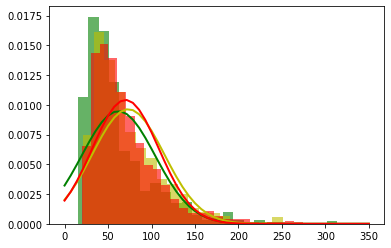

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


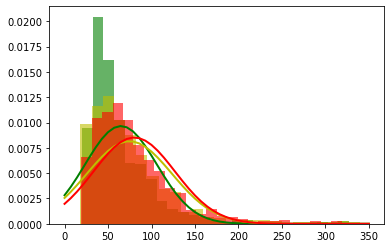

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


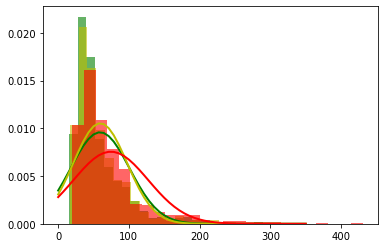

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


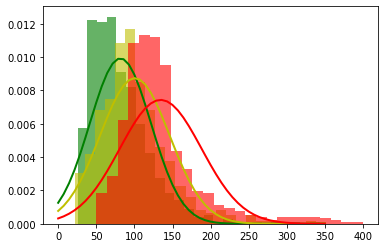

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


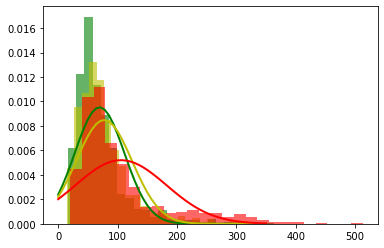

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


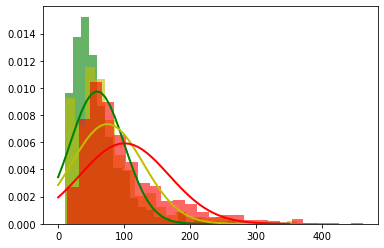

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


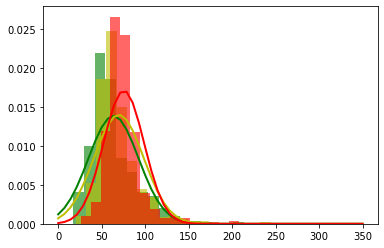

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


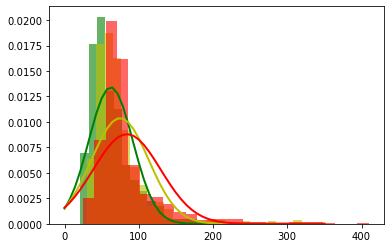

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


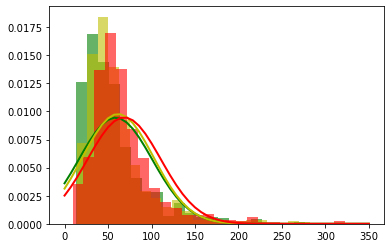

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


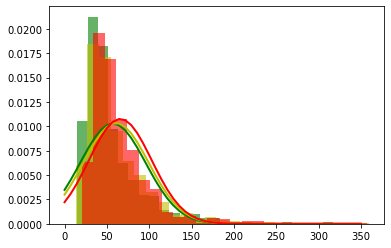

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


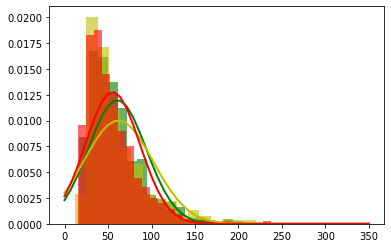

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


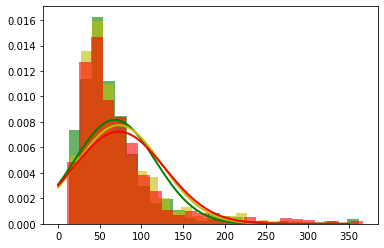

<ipython-input-46-a82febd698ac>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p1, 'k', linewidth=2,color='g')
<ipython-input-46-a82febd698ac>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p2, 'k', linewidth=2,color='y')
<ipython-input-46-a82febd698ac>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p3, 'k', linewidth=2,color='r')


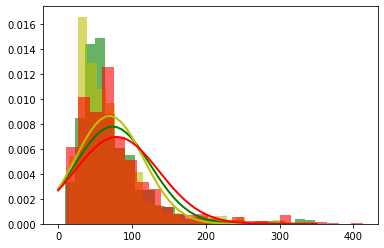

In [46]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu_2=np.zeros([13,3])
std_2=np.zeros([13,3])
for count,i in enumerate(letters):
    var1=i[0]
    var2=i[1]
    var3=i[2]
    # Plot the histogram.
    plt.hist(var1, bins=25, density=True, alpha=0.6, color='g')
    plt.hist(var2, bins=25, density=True, alpha=0.6, color='y')
    plt.hist(var3, bins=25, density=True, alpha=0.6, color='r')
    # Fit a normal distribution to the data:
    mu1, std1 = norm.fit(var1)
    mu2, std2 = norm.fit(var2)
    mu3, std3 = norm.fit(var3)
    mu_2[count]=[mu1,mu2,mu3]
    std_2[count]=[std1,std2,std3]
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(0, 350)
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p1, 'k', linewidth=2,color='g')
    plt.plot(x, p2, 'k', linewidth=2,color='y')
    plt.plot(x, p3, 'k', linewidth=2,color='r')
    count2=str(count)
    plt.savefig('model_585_'+count2+'.png')
    plt.show()

In [47]:
#370
mu_1

array([[ 66.06196042,  64.15394638,  69.69732319],
       [ 62.11206912,  70.09769469,  77.48680048],
       [ 60.55406466,  59.81081546,  66.94638309],
       [ 78.35625697,  98.6455285 , 117.96066039],
       [ 66.16358082,  84.24353913,  95.22134251],
       [ 61.08470513,  71.85627778,  84.25883913],
       [ 66.21109643,  70.17088937,  77.70833333],
       [ 60.23877982,  68.10060725,  74.5028314 ],
       [ 61.16572018,  64.37291836,  71.13132174],
       [ 57.65664326,  64.72787536,  66.97261739],
       [ 62.40183501,  58.06749034,  58.69928841],
       [ 67.92549833,  69.71266039,  74.42916908],
       [ 70.81574638,  77.42072271,  78.72764203]])

In [48]:
#585
mu_2

array([[ 61.94480992,  73.29059179,  70.11904493],
       [ 64.85825195,  74.58882995,  80.13355362],
       [ 59.22813266,  59.45994976,  74.50112705],
       [ 81.65619621, 100.58100773, 134.48153478],
       [ 69.68289298,  77.36671353, 105.70635411],
       [ 59.08157191,  74.71425942, 100.55921546],
       [ 63.65177313,  69.73181159,  75.47254928],
       [ 62.2487447 ,  74.79928213,  84.02246522],
       [ 58.59629877,  61.56315169,  68.60068116],
       [ 57.12156856,  60.79413865,  65.88362899],
       [ 60.56508027,  61.85432657,  55.29857729],
       [ 68.12082887,  72.89573333,  72.96188357],
       [ 73.67207748,  69.4180372 ,  79.26197874]])

In [51]:
#370
std_1

array([[45.15077403, 35.18360324, 40.37835667],
       [40.87586178, 47.16463234, 59.88493405],
       [36.05379499, 42.17105747, 45.50423279],
       [44.3294077 , 47.88031546, 52.38370459],
       [36.3580313 , 50.89850503, 60.90950444],
       [45.59742695, 51.16889487, 58.02039423],
       [34.64121516, 31.15871455, 29.88288529],
       [32.04700303, 35.22153182, 29.81077061],
       [38.69804984, 46.13077149, 49.57280951],
       [34.28419334, 45.181514  , 40.32727656],
       [38.69525734, 40.61335038, 35.31106831],
       [42.91155839, 48.54274144, 54.24132856],
       [45.39093824, 51.12510991, 59.27299722]])

In [52]:
#585
std_2

array([[42.16256403, 41.43319927, 38.31183368],
       [41.33450243, 48.94832852, 46.8267015 ],
       [41.62374158, 37.90169776, 52.84519741],
       [40.18803842, 45.64784475, 53.66320211],
       [41.88169889, 47.00535963, 76.68283996],
       [40.88419545, 54.34853357, 67.36249036],
       [28.83675513, 28.53690843, 23.34684613],
       [29.75212109, 38.44594095, 45.35032115],
       [42.20993714, 40.81828002, 42.11296875],
       [38.76996087, 38.59640043, 37.06872047],
       [33.27082838, 39.87920487, 31.23164271],
       [48.81222763, 51.45116476, 55.0403265 ],
       [51.17095467, 46.12095617, 57.31049489]])

# Try 2

# Step1: make a raster for each day in the dataframe and export it

In [5]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_585'
dictionary_585={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_585[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [6]:
#df5_1=dictionary_585['EC-Earth3-ssp585'][0:2]
#df5_2=dictionary_585['EC-Earth3-ssp585'][7302:18252]
#df5=pd.concat([df5_1,df5_2])
#df6_1=dictionary_585['EC-Earth3-Veg-ssp585'][0:2]
#df6_2=dictionary_585['EC-Earth3-Veg-ssp585'][7302:18252]
#df6=pd.concat([df6_1,df6_2])
df7_1=dictionary_585['INM-CM4-8-ssp585'][0:2]
df7_2=dictionary_585['INM-CM4-8-ssp585'][7302:18252]
df7=pd.concat([df7_1,df7_2])
df8_1=dictionary_585['INM-CM5-0-ssp585'][0:2]
df8_2=dictionary_585['INM-CM5-0-ssp585'][7302:18252]
df8=pd.concat([df8_1,df8_2])
df9_1=dictionary_585['MPI-ESM1-2-HR-ssp585'][0:2]
df9_2=dictionary_585['MPI-ESM1-2-HR-ssp585'][7302:18252]
df9=pd.concat([df9_1,df9_2])
df10_1=dictionary_585['MPI-ESM1-2-LR-ssp585'][0:2]
df10_2=dictionary_585['MPI-ESM1-2-LR-ssp585'][7302:18252]
df10=pd.concat([df10_1,df10_2])
df11_1=dictionary_585['MRI-ESM2-0-ssp585'][0:2]
df11_2=dictionary_585['MRI-ESM2-0-ssp585'][7302:18252]
df11=pd.concat([df11_1,df11_2])
df12_1=dictionary_585['NorESM2-LM-ssp585'][0:2]
df12_2=dictionary_585['NorESM2-LM-ssp585'][7302:18252]
df12=pd.concat([df12_1,df12_2])
df13_1=dictionary_585['NorESM2-MM-ssp585'][0:2]
df13_2=dictionary_585['NorESM2-MM-ssp585'][7302:18252]
df13=pd.concat([df13_1,df13_2])

#df5=dictionary_585['EC-Earth3-ssp585'][7300:18252]
#df6=dictionary_585['EC-Earth3-Veg-ssp585'][7300:18252]
#df7=dictionary_585['INM-CM4-8-ssp585'][7300:18252] #2035-2065
#df8=dictionary_585['INM-CM5-0-ssp585'][7300:18252]
#df9=dictionary_585['MPI-ESM1-2-HR-ssp585'][7300:18252]
#df10=dictionary_585['MPI-ESM1-2-LR-ssp585'][7300:18252]
#df11=dictionary_585['MRI-ESM2-0-ssp585'][7300:18252]
#df12=dictionary_585['NorESM2-LM-ssp585'][7300:18252]
#df13=dictionary_585['NorESM2-MM-ssp585'][7300:18252]

In [34]:

df2=dictionary_585['ACCESS-ESM1-5-ssp585'][7300:18252]
df3=dictionary_585['BCC-CSM2-MR-ssp585'][7300:18252]
df4=dictionary_585['CanESM5-ssp585'][7300:18252]
df5=dictionary_585['EC-Earth3-ssp585'][7300:18252]
df6=dictionary_585['EC-Earth3-Veg-ssp585'][7300:18252]
df7=dictionary_585['INM-CM4-8-ssp585'][7300:18252] #2035-2065
df8=dictionary_585['INM-CM5-0-ssp585'][7300:18252]
df9=dictionary_585['MPI-ESM1-2-HR-ssp585'][7300:18252]
df10=dictionary_585['MPI-ESM1-2-LR-ssp585'][7300:18252]
df11=dictionary_585['MRI-ESM2-0-ssp585'][7300:18252]
df12=dictionary_585['NorESM2-LM-ssp585'][7300:18252]
df13=dictionary_585['NorESM2-MM-ssp585'][7300:18252]

In [22]:
df13.iloc[210]

4     122.97
5     118.49
6     113.94
7     103.38
11    168.56
12    165.62
13    159.21
14    134.29
15    117.31
16    115.94
17    109.36
18     95.92
28    147.65
29    129.45
30    124.14
31    104.31
32     96.25
33     99.49
34     87.83
35     71.40
47     55.92
48     62.04
49     40.91
Name: 2035-7-28, dtype: float64

In [7]:
def func_make_raster(df,folder_name):
    #generate a list of coordinates present in the dataframe 
    isExist = os.path.exists(folder_name)
    if not isExist:
        os.mkdir(folder_name)
    longitudes=df.iloc[0]
    lattitudes=df.iloc[1]
    coordinates=np.vstack((longitudes, lattitudes)).T
    # make the framework for a raster
    rRes=0.25
    min_x=df.iloc[0].min()
    max_x=df.iloc[0].max()
    min_y=df.iloc[1].min()
    max_y=df.iloc[1].max()
    xrange=np.arange(min_x,max_x+rRes,rRes)
    yrange=np.arange(min_y,max_y+rRes,rRes)
    yrange_2=np.flip(yrange)
    gridX,gridY = np.meshgrid(xrange, yrange_2)
    #problem: we have raster with unprojected coordinates, hence we need to define the average width and height resolution and begin point(topleft) to export the raster
    #coordinates top left:
    longitude_top_left=df.iloc[0].min()-0.125
    lattitude_top_left=df.iloc[1].max()+0.125
    crs_wgs = proj.Proj('EPSG:4326') #were using WGS84 geographic
    crs_bng = proj.Proj('EPSG:32643')
    topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
    #average resolution:
    longitude_top_right=df.iloc[0].max()+0.125
    lattitude_top_right=df.iloc[1].max()+0.125
    topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
    res_width=(topright_x-topleft_x)/4
    longitude_bottom_left=df.iloc[0].min()-0.125
    lattitude_bottom_left=df.iloc[1].min()-0.125
    bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
    res_height=(topleft_y-bottomleft_y)/8
    #set-up projection variables
    path_projection = r'MMR_Area_and_SubBasins\mmr_boundary_raster_final.tif'
    open_projection=gdal.Open(path_projection)
    projection = open_projection.GetProjection()
    geotrans=(topleft_x, res_width,0.0,topleft_y,0.0,-res_height) 
    #fill in values into raster and export it
    for i in range(2,len(df)):
        values=list(df.iloc[i])
        grid = griddata(coordinates, values, (gridX,gridY), method='nearest')
        outputPath = os.path.join(folder_name,df.iloc[i].name +'.tif')
        cv2.imwrite(outputPath, grid)
        dataset2 = gdal.Open(outputPath, gdal.GA_Update)
        dataset2.SetGeoTransform(geotrans)
        dataset2.SetProjection(projection)

In [ ]:
#func_make_raster(df1,r'CMIP\585\model_1_585_rasters')
#func_make_raster(df2,r'CMIP\585\model_2_585_rasters')
#func_make_raster(df3,r'CMIP\585\model_3_585_rasters')
#func_make_raster(df4,r'CMIP\585\model_4_585_rasters')
#func_make_raster(df5,r'CMIP\585\model_5_585_rasters')
#func_make_raster(df6,r'CMIP\585\model_6_585_rasters')
func_make_raster(df7,r'CMIP\585\model_7_585_rasters')
func_make_raster(df8,r'CMIP\585\model_8_585_rasters')
func_make_raster(df9,r'CMIP\585\model_9_585_rasters')
func_make_raster(df10,r'CMIP\585\model_10_585_rasters')
func_make_raster(df11,r'CMIP\585\model_11_585_rasters')
func_make_raster(df12,r'CMIP\585\model_12_585_rasters')
func_make_raster(df13,r'CMIP\585\model_13_585_rasters')

<ipython-input-7-a55a27e2af5f>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-7-a55a27e2af5f>:29: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-7-a55a27e2af5f>:33: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)


In [7]:
func_make_raster(df1,r'CMIP\585\model_1_585_rasters')
func_make_raster(df2,r'CMIP\585\model_2_585_rasters')
func_make_raster(df3,r'CMIP\585\model_3_585_rasters')
func_make_raster(df4,r'CMIP\585\model_4_585_rasters')
func_make_raster(df5,r'CMIP\585\model_5_585_rasters')
func_make_raster(df6,r'CMIP\585\model_6_585_rasters')
func_make_raster(df7,r'CMIP\585\model_7_585_rasters')
func_make_raster(df8,r'CMIP\585\model_8_585_rasters')
func_make_raster(df9,r'CMIP\585\model_9_585_rasters')
func_make_raster(df10,r'CMIP\585\model_10_585_rasters')
func_make_raster(df11,r'CMIP\585\model_11_585_rasters')
func_make_raster(df12,r'CMIP\585\model_12_585_rasters')
func_make_raster(df13,r'CMIP\585\model_13_585_rasters')

<ipython-input-6-1e290bfe27ac>:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-6-1e290bfe27ac>:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-6-1e290bfe27ac>:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
<ipython-input-6-1e290bfe27ac>:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

In [8]:
#executes func1_usable_df
inputFolder=r'CMIP\csv_files_370'
dictionary_370={}
for model_name in os.listdir(inputFolder):
    inputPath = os.path.join(inputFolder, model_name)
    parts = model_name.split(".")
    df_name= parts[0]
    df=pd.read_csv(inputPath,header=None)
    dictionary_370[df_name]=func1_usable_df(df) 
#df3=pd.read_csv(r'CMIP\csv_files\.csv')
#df4=func1_usable_df(df3)

In [9]:
df1=dictionary_370['ACCESS-CM2-ssp370'][7300:18252]
df2=dictionary_370['ACCESS-ESM1-5-ssp370'][7300:18252]
df3=dictionary_370['BCC-CSM2-MR-ssp370'][7300:18252]
df4=dictionary_370['CanESM5-ssp370'][7300:18252]
df5=dictionary_370['EC-Earth3-ssp370'][7300:18252]
df6=dictionary_370['EC-Earth3-Veg-ssp370'][7300:18252]
df7=dictionary_370['INM-CM4-8-ssp370'][7300:18252]
df8=dictionary_370['INM-CM5-0-ssp370'][7300:18252]
df9=dictionary_370['MPI-ESM1-2-HR-ssp370'][7300:18252]
df10=dictionary_370['MPI-ESM1-2-LR-ssp370'][7300:18252]
df11=dictionary_370['MRI-ESM2-0-ssp370'][7300:18252]
df12=dictionary_370['NorESM2-LM-ssp370'][7300:18252]
df13=dictionary_370['NorESM2-MM-ssp370'][7300:18252]

In [10]:
func_make_raster(df1,r'CMIP\370\model_1_370_rasters')
func_make_raster(df2,r'CMIP\370\model_2_370_rasters')
func_make_raster(df3,r'CMIP\370\model_3_370_rasters')
func_make_raster(df4,r'CMIP\370\model_4_370_rasters')
func_make_raster(df5,r'CMIP\370\model_5_370_rasters')
func_make_raster(df6,r'CMIP\370\model_6_370_rasters')
func_make_raster(df7,r'CMIP\370\model_7_370_rasters')
func_make_raster(df8,r'CMIP\370\model_8_370_rasters')
func_make_raster(df9,r'CMIP\370\model_9_370_rasters')
func_make_raster(df10,r'CMIP\370\model_10_370_rasters')
func_make_raster(df11,r'CMIP\370\model_11_370_rasters')
func_make_raster(df12,r'CMIP\370\model_12_370_rasters')
func_make_raster(df13,r'CMIP\370\model_13_370_rasters')

<ipython-input-6-1e290bfe27ac>:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topleft_x, topleft_y = proj.transform(crs_wgs, crs_bng,lattitude_top_left,longitude_top_left)
<ipython-input-6-1e290bfe27ac>:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  topright_x, topright_y = proj.transform(crs_wgs, crs_bng,lattitude_top_right,longitude_top_right)
<ipython-input-6-1e290bfe27ac>:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bottomleft_x, bottomleft_y = proj.transform(crs_wgs, crs_bng,lattitude_bottom_left,longitude_bottom_left)
<ipython-input-6-1e290bfe27ac>:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

# Step 2 link the rasters with the subbassins

In [11]:
#link raster data with the subbassins =, main
def func_link_subbassins(input_Folder,output_Folder):
    os.mkdir(output_Folder)
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\HECHMSTrial3_Subbasin_Boundaries_WGS84_V3.shp')
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(input_Folder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()
                gdf2['name']=shapefile['name']
    return parts

In [12]:
func_link_subbassins(r'CMIP\370\model_1_370_rasters',r'CMIP\370\model_1_370_subbassins')
func_link_subbassins(r'CMIP\370\model_2_370_rasters',r'CMIP\370\model_2_370_subbassins')
func_link_subbassins(r'CMIP\370\model_3_370_rasters',r'CMIP\370\model_3_370_subbassins')
func_link_subbassins(r'CMIP\370\model_4_370_rasters',r'CMIP\370\model_4_370_subbassins')
func_link_subbassins(r'CMIP\370\model_5_370_rasters',r'CMIP\370\model_5_370_subbassins')
func_link_subbassins(r'CMIP\370\model_6_370_rasters',r'CMIP\370\model_6_370_subbassins')
func_link_subbassins(r'CMIP\370\model_7_370_rasters',r'CMIP\370\model_7_370_subbassins')
func_link_subbassins(r'CMIP\370\model_8_370_rasters',r'CMIP\370\model_8_370_subbassins')
func_link_subbassins(r'CMIP\370\model_9_370_rasters',r'CMIP\370\model_9_370_subbassins')
func_link_subbassins(r'CMIP\370\model_10_370_rasters',r'CMIP\370\model_10_370_subbassins')
func_link_subbassins(r'CMIP\370\model_11_370_rasters',r'CMIP\370\model_11_370_subbassins')
func_link_subbassins(r'CMIP\370\model_12_370_rasters',r'CMIP\370\model_12_370_subbassins')
func_link_subbassins(r'CMIP\370\model_13_370_rasters',r'CMIP\370\model_13_370_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


['2064', '12', '31']

In [13]:
func_link_subbassins(r'CMIP\585\model_1_585_rasters',r'CMIP\585\model_1_585_subbassins')
func_link_subbassins(r'CMIP\585\model_2_585_rasters',r'CMIP\585\model_2_585_subbassins')
func_link_subbassins(r'CMIP\585\model_3_585_rasters',r'CMIP\585\model_3_585_subbassins')
func_link_subbassins(r'CMIP\585\model_4_585_rasters',r'CMIP\585\model_4_585_subbassins')
func_link_subbassins(r'CMIP\585\model_5_585_rasters',r'CMIP\585\model_5_585_subbassins')
func_link_subbassins(r'CMIP\585\model_6_585_rasters',r'CMIP\585\model_6_585_subbassins')
func_link_subbassins(r'CMIP\585\model_7_585_rasters',r'CMIP\585\model_7_585_subbassins')
func_link_subbassins(r'CMIP\585\model_8_585_rasters',r'CMIP\585\model_8_585_subbassins')
func_link_subbassins(r'CMIP\585\model_9_585_rasters',r'CMIP\585\model_9_585_subbassins')
func_link_subbassins(r'CMIP\585\model_10_585_rasters',r'CMIP\585\model_10_585_subbassins')
func_link_subbassins(r'CMIP\585\model_11_585_rasters',r'CMIP\585\model_11_585_subbassins')
func_link_subbassins(r'CMIP\585\model_12_585_rasters',r'CMIP\585\model_12_585_subbassins')
func_link_subbassins(r'CMIP\585\model_13_585_rasters',r'CMIP\585\model_13_585_subbassins')

KeyboardInterrupt: 

In [25]:
func_link_subbassins(r'CMIP\model_4_585_rasters',r'CMIP\model_4_585_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


['2100', '12', '31']

['2100', '12', '31']

In [9]:
func_link_subbassins(r'CMIP\model_1_370_rasters',r'CMIP\model_1_370_subbassins')
func_link_subbassins(r'CMIP\model_2_370_rasters',r'CMIP\model_2_370_subbassins')
func_link_subbassins(r'CMIP\model_3_370_rasters',r'CMIP\model_3_370_subbassins')
func_link_subbassins(r'CMIP\model_4_370_rasters',r'CMIP\model_4_370_subbassins')
func_link_subbassins(r'CMIP\model_5_370_rasters',r'CMIP\model_5_370_subbassins')
func_link_subbassins(r'CMIP\model_6_370_rasters',r'CMIP\model_6_370_subbassins')
func_link_subbassins(r'CMIP\model_7_370_rasters',r'CMIP\model_7_370_subbassins')
func_link_subbassins(r'CMIP\model_8_370_rasters',r'CMIP\model_8_370_subbassins')
func_link_subbassins(r'CMIP\model_9_370_rasters',r'CMIP\model_9_370_subbassins')
func_link_subbassins(r'CMIP\model_10_370_rasters',r'CMIP\model_10_370_subbassins')
func_link_subbassins(r'CMIP\model_11_370_rasters',r'CMIP\model_11_370_subbassins')
func_link_subbassins(r'CMIP\model_12_370_rasters',r'CMIP\model_12_370_subbassins')
func_link_subbassins(r'CMIP\model_13_370_rasters',r'CMIP\model_13_370_subbassins')

['2100', '12', '31']

In [ ]:
func_link_subbassins(r'CMIP\model_1_585_rasters',r'CMIP\model_1_585_subbassins')
func_link_subbassins(r'CMIP\model_2_585_rasters',r'CMIP\model_2_585_subbassins')
func_link_subbassins(r'CMIP\model_3_585_rasters',r'CMIP\model_3_585_subbassins')
func_link_subbassins(r'CMIP\model_4_585_rasters',r'CMIP\model_4_585_subbassins')

In [5]:
func_link_subbassins(r'CMIP\model_5_585_rasters',r'CMIP\model_5_585_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


KeyboardInterrupt: 

In [ ]:
func_link_subbassins(r'CMIP\model_6_585_rasters',r'CMIP\model_6_585_subbassins')
func_link_subbassins(r'CMIP\model_7_585_rasters',r'CMIP\model_7_585_subbassins')
func_link_subbassins(r'CMIP\model_8_585_rasters',r'CMIP\model_8_585_subbassins')
func_link_subbassins(r'CMIP\model_9_585_rasters',r'CMIP\model_9_585_subbassins')
func_link_subbassins(r'CMIP\model_10_585_rasters',r'CMIP\model_10_585_subbassins')
func_link_subbassins(r'CMIP\model_11_585_rasters',r'CMIP\model_11_585_subbassins')
func_link_subbassins(r'CMIP\model_12_585_rasters',r'CMIP\model_12_585_subbassins')
func_link_subbassins(r'CMIP\model_13_585_rasters',r'CMIP\model_13_585_subbassins')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [26]:
#link raster data with the subbassins =, main
def func_link_MMR(input_Folder,output_Folder):
    counter = 0
    shapefile = gpd.read_file(r'MMR_Area_and_SubBasins\MMR_Area_Boundary_WGS84_proj.shp')
    geoms = shapefile.geometry.values # list of shapely geometries
    gdf2=pd.DataFrame()
    gdf2['name']=shapefile['name']
    for file in  os.listdir(input_Folder):
        if file.endswith('tif'):
            file_path=os.path.join(input_Folder, file)
            with rasterio.open(file_path) as src:
                affine = src.transform
                array = src.read(1)
                df_zonal_stats = pd.DataFrame(zonal_stats(geoms, array, affine=affine,all_touched=True))
            gdf2 = pd.concat([gdf2, df_zonal_stats['mean']], axis=1) 
            file=file.replace('.tif', '')
            gdf2 = gdf2.rename({'mean':file},axis=1) 
            parts = file.split("-")
            if str(parts[1])+"-"+str(parts[2])=='12-31':
                gdf2['name']='MMR'
                gdf2=gdf2.set_index('name')
                out_filename = parts[0] + ".csv"
                outputPath = os.path.join(output_Folder, out_filename)
                gdf2.to_csv(outputPath)
                gdf2=pd.DataFrame()

In [4]:
#func_link_MMR(r'CMIP\model_1_370_rasters',r'CMIP\model_1_370_MMR')
#func_link_MMR(r'CMIP\model_2_370_rasters',r'CMIP\model_2_370_MMR')
#func_link_MMR(r'CMIP\model_3_370_rasters',r'CMIP\model_3_370_MMR')
func_link_MMR(r'CMIP\model_4_370_rasters',r'CMIP\model_4_370_MMR')
func_link_MMR(r'CMIP\model_5_370_rasters',r'CMIP\model_5_370_MMR')
func_link_MMR(r'CMIP\model_6_370_rasters',r'CMIP\model_6_370_MMR')
func_link_MMR(r'CMIP\model_7_370_rasters',r'CMIP\model_7_370_MMR')
func_link_MMR(r'CMIP\model_8_370_rasters',r'CMIP\model_8_370_MMR')
func_link_MMR(r'CMIP\model_9_370_rasters',r'CMIP\model_9_370_MMR')
func_link_MMR(r'CMIP\model_10_370_rasters',r'CMIP\model_10_370_MMR')
func_link_MMR(r'CMIP\model_11_370_rasters',r'CMIP\model_11_370_MMR')
func_link_MMR(r'CMIP\model_12_370_rasters',r'CMIP\model_12_370_MMR')
func_link_MMR(r'CMIP\model_13_370_rasters',r'CMIP\model_13_370_MMR')

C:\Users\Quint\anaconda3\envs\gds\envs\myenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [6]:
func_link_MMR(r'CMIP\model_3_370_rasters',r'CMIP\model_3_370_MMR')

In [27]:
func_link_MMR(r'CMIP\model_4_585_rasters',r'CMIP\model_4_585_MMR')

# calculate final values

In [28]:
#combine MMR and subbasin data, create total files
def func_combineren(inputFolder1,inputFolder2,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            file_path2=os.path.join(inputFolder2, file)
            df1 = pd.read_csv(file_path1,index_col='name')
            df2 = pd.read_csv(file_path2,index_col='name')
            df3 = pd.concat([df1, df2], axis=0) 
            outputPath=os.path.join(outputFolder, file)
            df3.to_csv(outputPath)
            df3=pd.DataFrame()

In [29]:
func_combineren(r'CMIP\model_4_585_subbassins',r'CMIP\model_4_585_MMR',r'CMIP\model_4_585_total')

In [8]:
func_combineren(r'CMIP\model_1_370_subbassins',r'CMIP\model_1_370_MMR',r'CMIP\model_1_370_total')
func_combineren(r'CMIP\model_2_370_subbassins',r'CMIP\model_2_370_MMR',r'CMIP\model_2_370_total')
func_combineren(r'CMIP\model_3_370_subbassins',r'CMIP\model_3_370_MMR',r'CMIP\model_3_370_total')
func_combineren(r'CMIP\model_4_370_subbassins',r'CMIP\model_4_370_MMR',r'CMIP\model_4_370_total')
func_combineren(r'CMIP\model_5_370_subbassins',r'CMIP\model_5_370_MMR',r'CMIP\model_5_370_total')
func_combineren(r'CMIP\model_6_370_subbassins',r'CMIP\model_6_370_MMR',r'CMIP\model_6_370_total')
func_combineren(r'CMIP\model_7_370_subbassins',r'CMIP\model_7_370_MMR',r'CMIP\model_7_370_total')
func_combineren(r'CMIP\model_8_370_subbassins',r'CMIP\model_8_370_MMR',r'CMIP\model_8_370_total')
func_combineren(r'CMIP\model_9_370_subbassins',r'CMIP\model_9_370_MMR',r'CMIP\model_9_370_total')
func_combineren(r'CMIP\model_10_370_subbassins',r'CMIP\model_10_370_MMR',r'CMIP\model_10_370_total')
func_combineren(r'CMIP\model_11_370_subbassins',r'CMIP\model_11_370_MMR',r'CMIP\model_11_370_total')
func_combineren(r'CMIP\model_12_370_subbassins',r'CMIP\model_12_370_MMR',r'CMIP\model_12_370_total')
func_combineren(r'CMIP\model_13_370_subbassins',r'CMIP\model_13_370_MMR',r'CMIP\model_13_370_total')

In [30]:
#calculate maximum rainfall
def func_max(inputFolder1,outputFolder):
    for file in  os.listdir(inputFolder1):
            file_path1=os.path.join(inputFolder1, file)
            df1 = pd.read_csv(file_path1,index_col='name')
            df2=pd.DataFrame()
            df3=pd.DataFrame()
            df2['date']=df1.idxmax(axis=1)
            df3['rainfall']=df1.max(axis=1)
            c=pd.concat([df2,df3],axis=1)
            outputPath=os.path.join(outputFolder, file)
            c.to_csv(outputPath)

In [14]:
func_max(r'CMIP\model_1_370_total',r'CMIP\model_1_370_max')
func_max(r'CMIP\model_2_370_total',r'CMIP\model_2_370_max')
func_max(r'CMIP\model_3_370_total',r'CMIP\model_3_370_max')
func_max(r'CMIP\model_4_370_total',r'CMIP\model_4_370_max')
func_max(r'CMIP\model_5_370_total',r'CMIP\model_5_370_max')
func_max(r'CMIP\model_6_370_total',r'CMIP\model_6_370_max')
func_max(r'CMIP\model_7_370_total',r'CMIP\model_7_370_max')
func_max(r'CMIP\model_8_370_total',r'CMIP\model_8_370_max')
func_max(r'CMIP\model_9_370_total',r'CMIP\model_9_370_max')
func_max(r'CMIP\model_10_370_total',r'CMIP\model_10_370_max')
func_max(r'CMIP\model_11_370_total',r'CMIP\model_11_370_max')
func_max(r'CMIP\model_12_370_total',r'CMIP\model_12_370_max')
func_max(r'CMIP\model_13_370_total',r'CMIP\model_13_370_max')

In [31]:
func_max(r'CMIP\model_4_585_total',r'CMIP\model_4_585_max')